# Credit Card Fraud Detection

## Set up

In [74]:
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn -q geopy xgboost plotly imbalanced-learn -q lightgbm optuna joblib fastapi pydantic uvicorn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn 
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Data Preproccessing

In [3]:
import json

kaggle_json = {"username":"maianhhhh","key":"8d3f50b1f090e3e599ab9e9261e28e10"}

os.makedirs('C:/Users/ADMIN/.kaggle', exist_ok=True)
with open('C:/Users/ADMIN/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)

# Đặt quyền (Windows)
!icacls "C:\Users\ADMIN\.kaggle\kaggle.json" /grant Everyone:F

processed file: C:\Users\ADMIN\.kaggle\kaggle.json
Successfully processed 1 files; Failed processing 0 files


In [4]:
!kaggle datasets download -d kartik2112/fraud-detection -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0




  0%|          | 0.00/202M [00:00<?, ?B/s]
 30%|███       | 61.0M/202M [00:00<00:00, 639MB/s]
 63%|██████▎   | 128M/202M [00:00<00:00, 670MB/s] 
 98%|█████████▊| 198M/202M [00:00<00:00, 696MB/s]
100%|██████████| 202M/202M [00:00<00:00, 682MB/s]


In [5]:
data_train = pd.read_csv('data/fraudTrain.csv')
data_test = pd.read_csv('data/fraudTest.csv')
df = pd.concat([data_train, data_test], ignore_index=True)

## EDA

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
df.info()
df.isnull().sum()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [8]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [9]:
data_columns = df.columns.tolist()

columns = []

with open('column_names.txt', 'w') as f:
    for column in data_columns:
        values = f'{column}: {data_train[column].isnull().sum()}: {data_train[column].dtype}'
        columns.append(values)

In [10]:
correlation = []
with open('column_names.txt', 'w') as f:
    for column in data_columns:
        if data_train[column].dtype == 'int64' or data_train[column].dtype == 'float64':
            correlation.append((column, data_train[column].corr(data_train['is_fraud'])))

In [11]:
corr_df = pd.DataFrame(correlation)

In [12]:
corr_df.sort_values(by=1, ascending=False).head(50)

,0,1
10,is_fraud,1.000000
2,amt,0.219404
6,city_pop,0.002136
4,lat,0.001894
8,merch_lat,0.001741
9,merch_long,0.001721
5,long,0.001721
1,cc_num,-0.000981
3,zip,-0.002162
0,Unnamed: 0,-0.004767


Tỷ lệ gian lận: 0.5210%


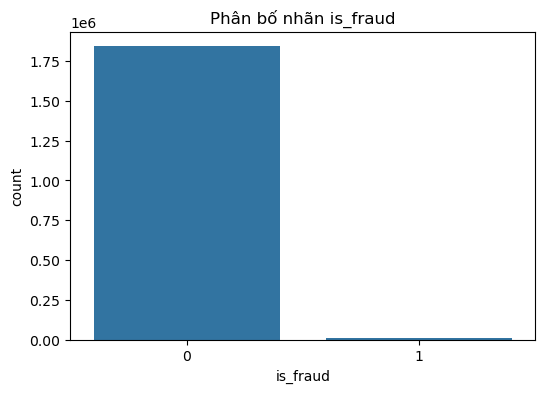

Train fraud rate: 0.005788651743883394
Test fraud rate: 0.0038598644278853163


In [13]:
# Tỷ lệ gian lận
fraud_rate = df['is_fraud'].mean() * 100
print(f"Tỷ lệ gian lận: {fraud_rate:.4f}%")

# Visualize
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title('Phân bố nhãn is_fraud')
plt.show()

# Tỷ lệ theo tập
print("Train fraud rate:", data_train['is_fraud'].mean())
print("Test fraud rate:", data_test['is_fraud'].mean())

### Devired KRIs

In [14]:
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (pd.to_datetime('today') - df['dob']).dt.days // 365
df['job_clean'] = df['job'].str.lower().str.strip()

In [15]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['is_night'] = df['hour'].between(0, 5).astype(int)

In [16]:
# Hàm Haversine vectorized
def haversine_vectorized(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # km

# Tính distance
df['distance_km'] = haversine_vectorized(
    df['lat'], df['long'],
    df['merch_lat'], df['merch_long']
)

In [17]:
print(df['distance_km'].describe())

count    1.852394e+06
mean     7.611173e+01
std      2.911697e+01
min      2.225452e-02
25%      5.532009e+01
50%      7.821638e+01
75%      9.850947e+01
max      1.521172e+02
Name: distance_km, dtype: float64


In [18]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['date'] = df['trans_date_trans_time'].dt.date
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek  # 0=Mon
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['month'] = df['trans_date_trans_time'].dt.month

df = df.sort_values(['cc_num', 'trans_date_trans_time']).reset_index(drop=True)

In [19]:
def count_1h_rolling(group):
    # group đã được sort theo thời gian
    group = group.set_index('trans_date_trans_time')
    rolling_count = group['trans_num'].rolling(window='1H', closed='left').count()
    return rolling_count.reset_index(drop=True)

df['txn_count_1h'] = df.groupby('cc_num').apply(count_1h_rolling).reset_index(drop=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\757873978.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='1H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\757873978.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='1H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\757873978.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='1H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\757873978.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='1H', closed='left').count()
C:\Users\ADMIN\AppDa

In [20]:
def count_24h_rolling(group):
    # group đã được sort theo thời gian
    group = group.set_index('trans_date_trans_time')
    rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
    return rolling_count.reset_index(drop=True)

df['txn_count_24h'] = df.groupby('cc_num').apply(count_24h_rolling).reset_index(drop=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADM

In [21]:
def count_7d_rolling(group):
    # group đã được sort theo thời gian
    group = group.set_index('trans_date_trans_time')
    rolling_count = group['trans_num'].rolling(window='7D', closed='left').count()
    return rolling_count.reset_index(drop=True)

# Áp dụng cho từng cc_num
df['txn_count_7d'] = df.groupby('cc_num').apply(count_24h_rolling).reset_index(drop=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3428992433.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rolling_count = group['trans_num'].rolling(window='24H', closed='left').count()
C:\Users\ADM

In [22]:
sample_card = df[df['cc_num'] == df['cc_num'].iloc[1000]]
print(sample_card[['trans_date_trans_time', 'txn_count_7d']].head(10))

  trans_date_trans_time  txn_count_7d
0   2019-01-01 12:47:15           NaN
1   2019-01-02 08:44:57           1.0
2   2019-01-02 08:47:36           2.0
3   2019-01-02 12:38:14           3.0
4   2019-01-02 13:10:46           3.0
5   2019-01-03 13:56:35           NaN
6   2019-01-03 17:05:10           1.0
7   2019-01-04 13:59:55           1.0
8   2019-01-04 21:17:22           1.0
9   2019-01-05 00:42:24           2.0


In [23]:
# Giao dịch trước (giây)
df['time_since_last_sec'] = df.groupby('cc_num')['unix_time'].diff().fillna(0)

# Giao dịch đêm khuya
df['is_night'] = df['hour'].between(0, 5).astype(int)
df['is_late_night'] = df['hour'].between(2, 4).astype(int)

# Tốc độ giao dịch (txn/h)
df['txn_per_hour'] = 1 / (df['time_since_last_sec'] / 3600).replace([np.inf], 0)

# Chuỗi giao dịch liên tiếp (streak)
df['txn_streak'] = df.groupby((df['time_since_last_sec'] > 3600).cumsum()).cumcount() + 1

In [24]:
df = df.sort_values(['cc_num', 'trans_date_trans_time'])
df['time_diff_hours'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds() / 3600
df['speed_kmh'] = df['distance_km'] / df['time_diff_hours'].replace(0, np.nan)

In [25]:
# Giao dịch nước ngoài
us_bounds = (-125, -65, 25, 50)  # [west, east, south, north]
df['is_international'] = ~(
    (df['merch_long'].between(us_bounds[0], us_bounds[1])) &
    (df['merch_lat'].between(us_bounds[2], us_bounds[3]))
).astype(int)

In [26]:
df['zip_mismatch'] = ((df['zip'] // 100) != (df['merch_lat'].round(1) * 100).astype(int)).astype(int)  # approx

### Univariate Analysis

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\2182608198.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = df.groupby('age_group')['is_fraud'].mean()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\2182608198.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_fraud.index, y=age_fraud.values, palette='Reds')


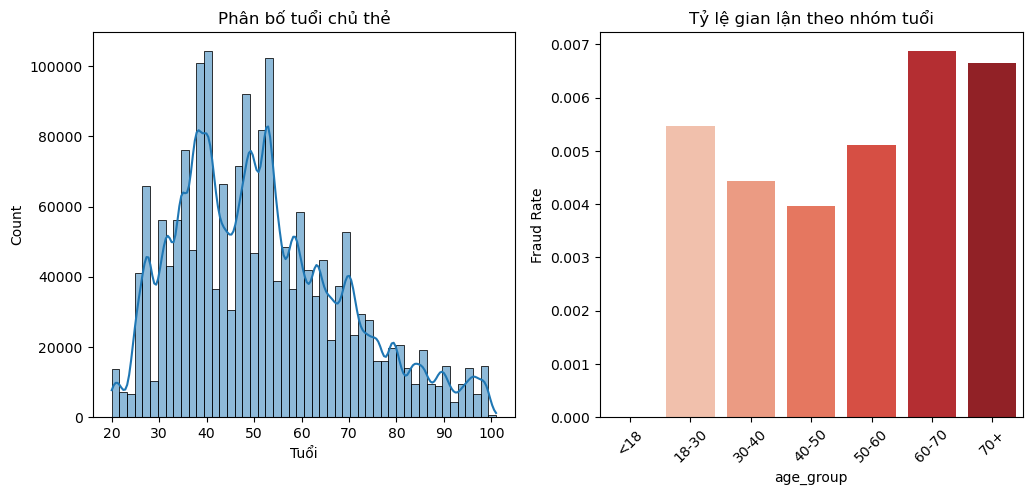

In [27]:
plt.figure(figsize=(12,5))

# Phân bố tuổi
plt.subplot(1,2,1)
sns.histplot(df['age'], bins=50, kde=True)
plt.title('Phân bố tuổi chủ thẻ')
plt.xlabel('Tuổi')

# Fraud rate theo nhóm tuổi
plt.subplot(1,2,2)
df['age_group'] = pd.cut(df['age'], bins=[0,18,30,40,50,60,70,120], labels=['<18','18-30','30-40','40-50','50-60','60-70','70+'])
age_fraud = df.groupby('age_group')['is_fraud'].mean()
sns.barplot(x=age_fraud.index, y=age_fraud.values, palette='Reds')
plt.title('Tỷ lệ gian lận theo nhóm tuổi')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

            mean    count
gender                   
F       0.004828  1014749
M       0.005673   837645


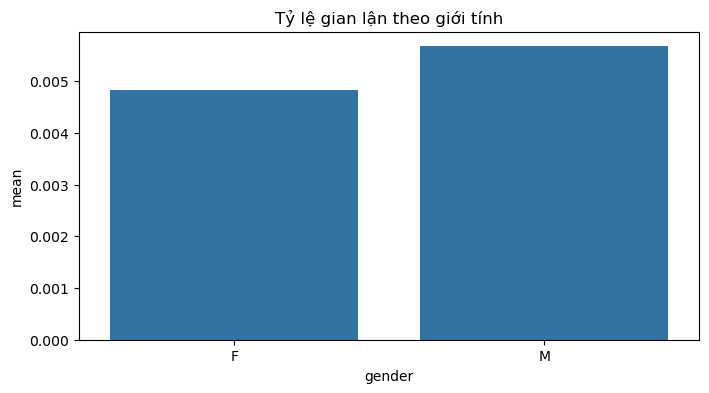

In [28]:
# Fraud rate theo giới tính
gender_fraud = df.groupby('gender')['is_fraud'].agg(['mean', 'count'])
print(gender_fraud)

# Visualize
plt.figure(figsize=(8,4))
sns.barplot(x=gender_fraud.index, y=gender_fraud['mean'])
plt.title('Tỷ lệ gian lận theo giới tính')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\2717300788.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_fraud.index, y=cat_fraud['mean'], palette='viridis')


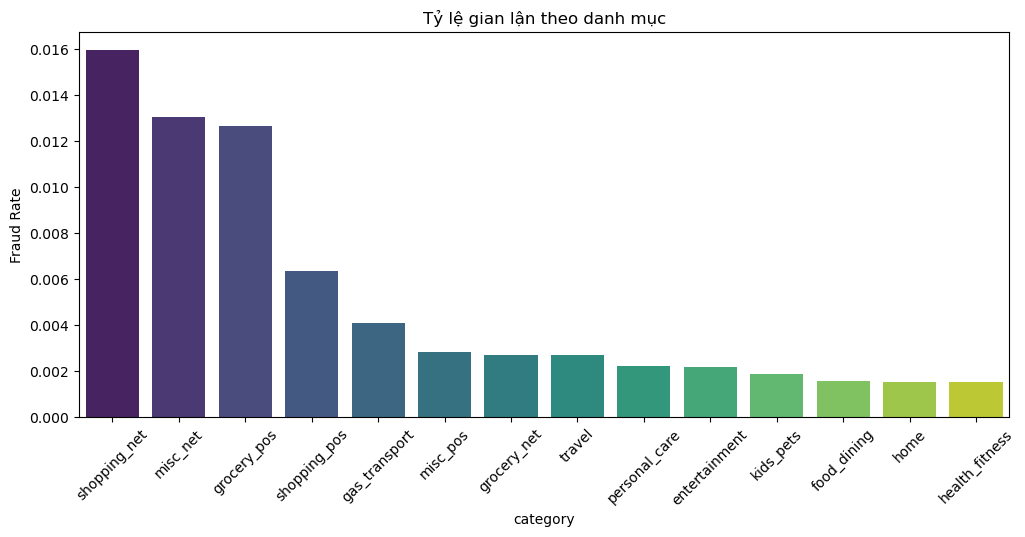

In [29]:
cat_fraud = df.groupby('category')['is_fraud'].agg(['mean', 'count']).sort_values('mean', ascending=False)
cat_fraud = cat_fraud[cat_fraud['count'] > 1000]  # lọc đủ mẫu

plt.figure(figsize=(12,5))
sns.barplot(x=cat_fraud.index, y=cat_fraud['mean'], palette='viridis')
plt.xticks(rotation=45)
plt.title('Tỷ lệ gian lận theo danh mục')
plt.ylabel('Fraud Rate')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\4124207372.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df[df['category'].isin(top_cats)].pivot_table(


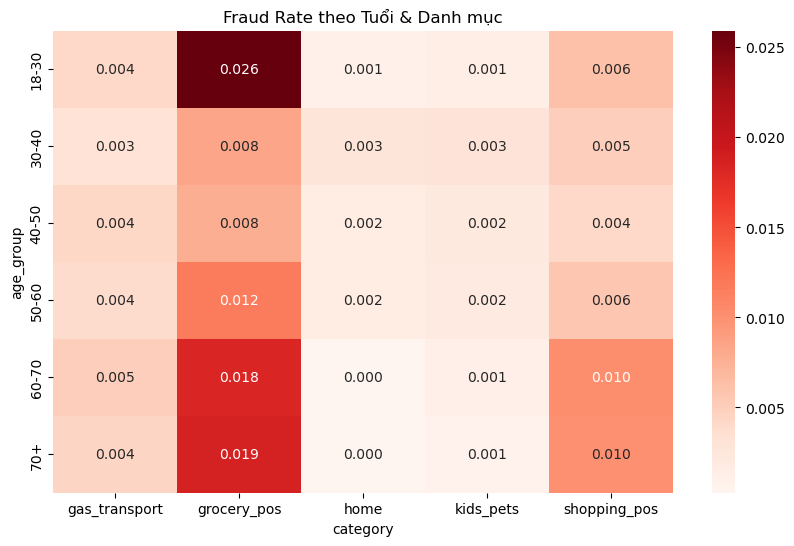

In [30]:
# Top 5 danh mục có fraud
top_cats = df['category'].value_counts().head(5).index
pivot = df[df['category'].isin(top_cats)].pivot_table(
    values='is_fraud', index='age_group', columns='category', aggfunc='mean'
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap='Reds', fmt='.3f')
plt.title('Fraud Rate theo Tuổi & Danh mục')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\3371555778.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_risk_jobs.index, x=top_risk_jobs['mean'], palette='dark:red')


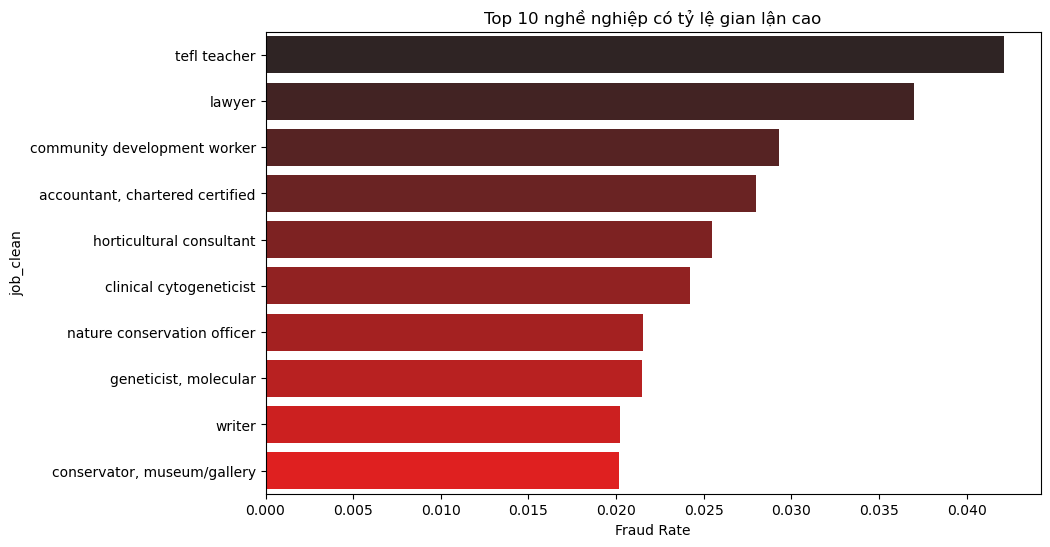

In [31]:
job_fraud = df.groupby('job_clean')['is_fraud'].agg(['mean', 'count'])
job_fraud = job_fraud[job_fraud['count'] > 100].sort_values('mean', ascending=False)

plt.figure(figsize=(10,6))
top_risk_jobs = job_fraud.head(10)
sns.barplot(y=top_risk_jobs.index, x=top_risk_jobs['mean'], palette='dark:red')
plt.title('Top 10 nghề nghiệp có tỷ lệ gian lận cao')
plt.xlabel('Fraud Rate')
plt.show()

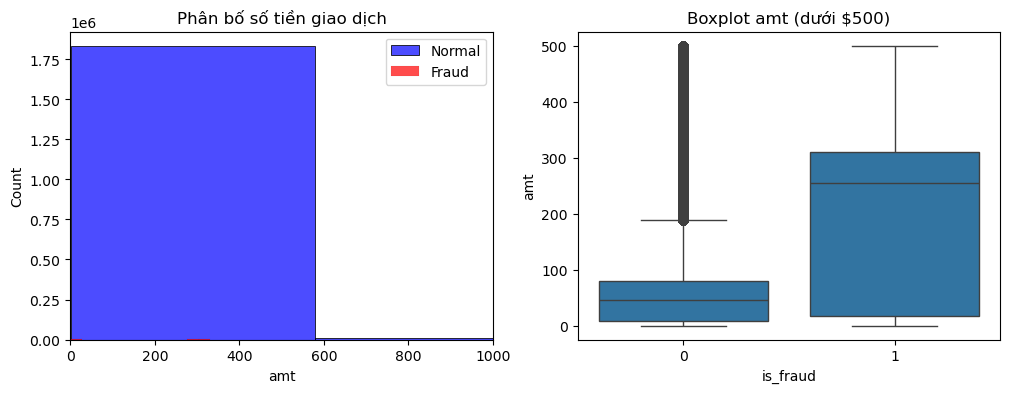

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data=df[df['is_fraud']==0], x='amt', bins=50, alpha=0.7, label='Normal', color='blue')
sns.histplot(data=df[df['is_fraud']==1], x='amt', bins=50, alpha=0.7, label='Fraud', color='red')
plt.legend()
plt.title('Phân bố số tiền giao dịch')
plt.xlim(0, 1000)

plt.subplot(1,2,2)
sns.boxplot(x='is_fraud', y='amt', data=df[df['amt'] < 500])
plt.title('Boxplot amt (dưới $500)')
plt.show()

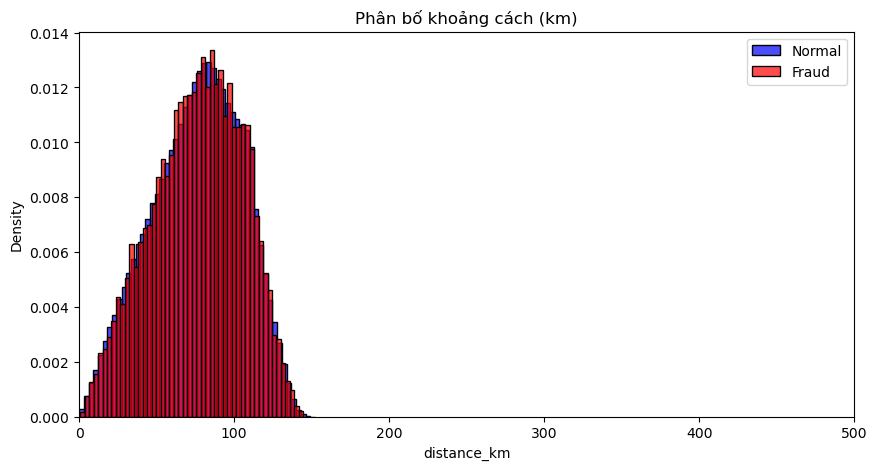

In [33]:
plt.figure(figsize=(10,5))

sns.histplot(df[df['is_fraud']==0]['distance_km'], bins=50, alpha=0.7, color='blue', label='Normal', stat='density')
sns.histplot(df[df['is_fraud']==1]['distance_km'], bins=50, alpha=0.7, color='red', label='Fraud', stat='density')
plt.xlim(0, 500)
plt.legend()
plt.title('Phân bố khoảng cách (km)')
plt.show()

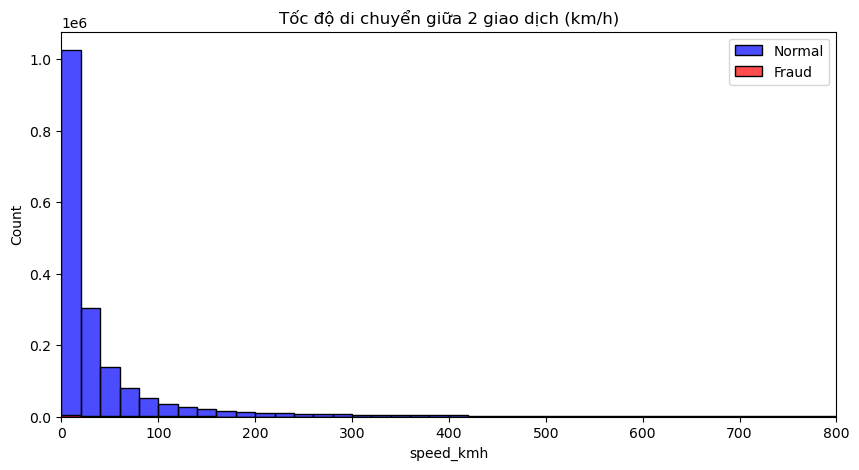

In [34]:
# Loại bỏ tốc độ vô lý (> 1000 km/h = máy bay)
valid_speed = df[df['speed_kmh'] < 1000]

plt.figure(figsize=(10,5))
sns.histplot(valid_speed[valid_speed['is_fraud']==0]['speed_kmh'], bins=50, alpha=0.7, color='blue', label='Normal')
sns.histplot(valid_speed[valid_speed['is_fraud']==1]['speed_kmh'], bins=50, alpha=0.7, color='red', label='Fraud')
plt.xlim(0, 800)
plt.title('Tốc độ di chuyển giữa 2 giao dịch (km/h)')
plt.legend()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\606740213.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_fraud.index, y=state_fraud['mean'], palette='Reds')


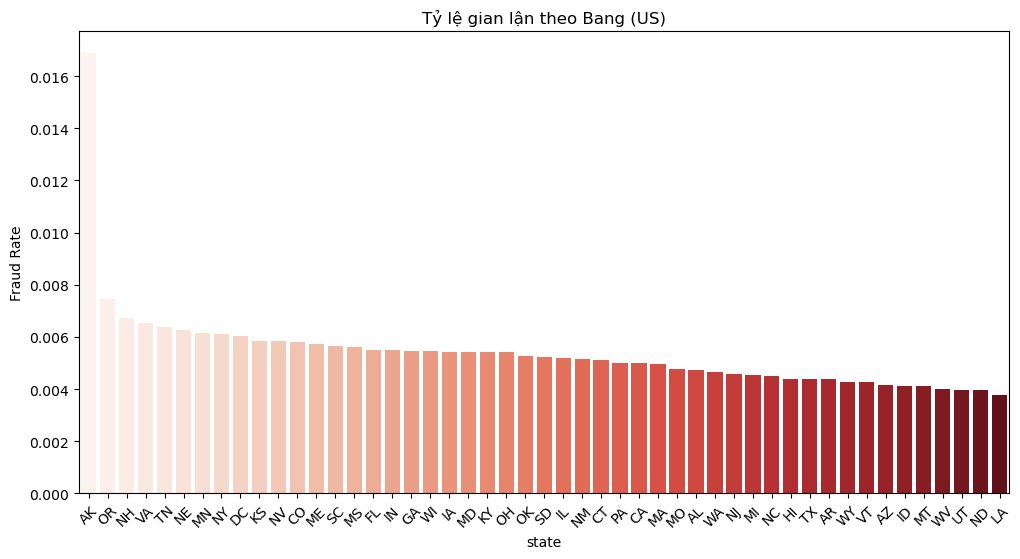

Top 5 rủi ro: ['AK', 'OR', 'NH', 'VA', 'TN']


In [35]:
state_fraud = df.groupby('state')['is_fraud'].agg(['mean', 'count']).sort_values('mean', ascending=False)
state_fraud = state_fraud[state_fraud['count'] > 1000]

plt.figure(figsize=(12,6))
sns.barplot(x=state_fraud.index, y=state_fraud['mean'], palette='Reds')
plt.xticks(rotation=45)
plt.title('Tỷ lệ gian lận theo Bang (US)')
plt.ylabel('Fraud Rate')
plt.show()

print("Top 5 rủi ro:", state_fraud.head(5).index.tolist())

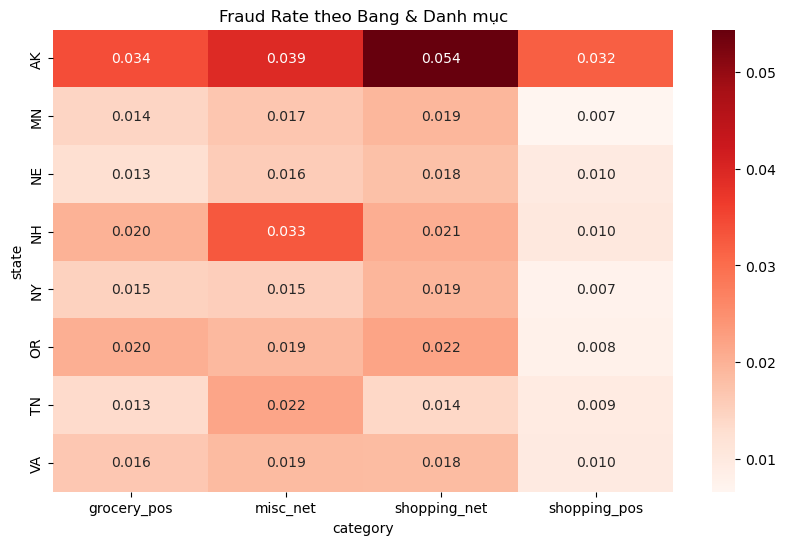

In [36]:
top_states = state_fraud.head(8).index
top_cats = ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos']

pivot = df[df['state'].isin(top_states) & df['category'].isin(top_cats)] \
    .pivot_table(values='is_fraud', index='state', columns='category', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap='Reds', fmt='.3f')
plt.title('Fraud Rate theo Bang & Danh mục')
plt.show()

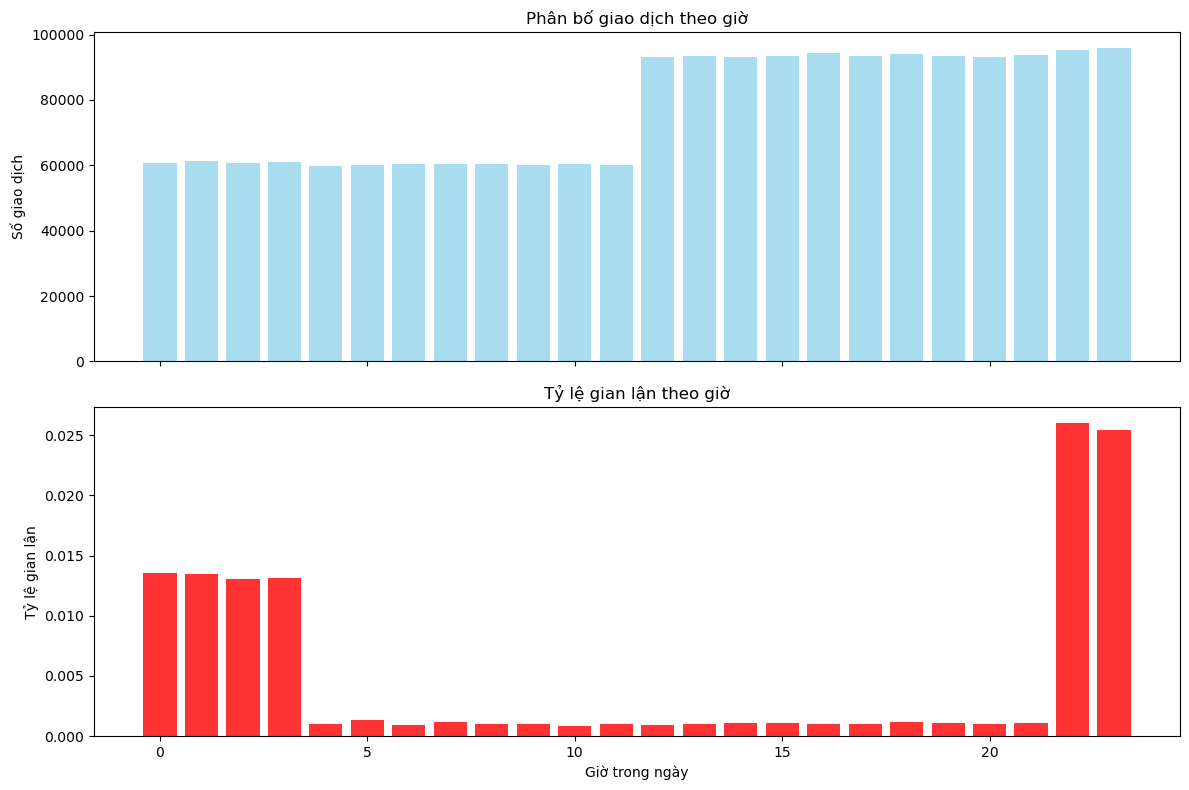

In [37]:
hour_count = df.groupby('hour').size()
hour_fraud = df.groupby('hour')['is_fraud'].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Số lượng giao dịch
ax1.bar(hour_count.index, hour_count.values, color='skyblue', alpha=0.7)
ax1.set_ylabel('Số giao dịch')
ax1.set_title('Phân bố giao dịch theo giờ')

# Tỷ lệ gian lận
ax2.bar(hour_fraud.index, hour_fraud.values, color='red', alpha=0.8)
ax2.set_ylabel('Tỷ lệ gian lận')
ax2.set_xlabel('Giờ trong ngày')
ax2.set_title('Tỷ lệ gian lận theo giờ')

plt.tight_layout()
plt.show()

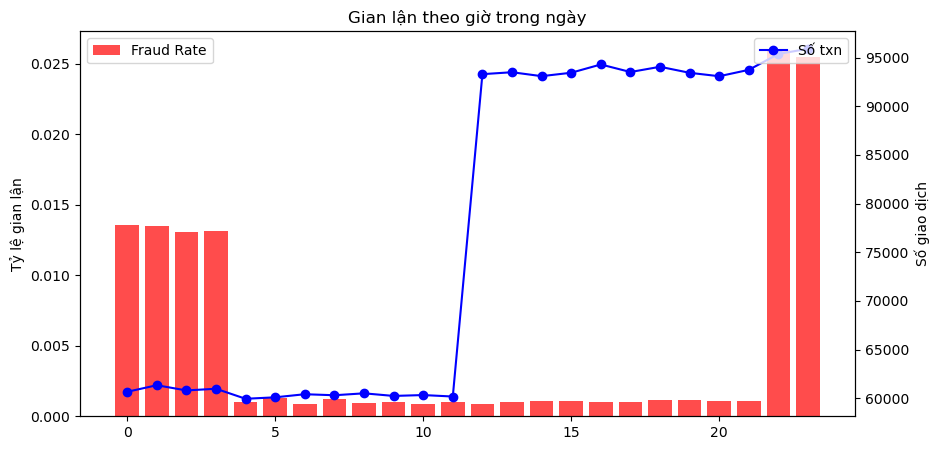

In [38]:
hour_fraud = df.groupby('hour')['is_fraud'].mean()
hour_count = df.groupby('hour').size()

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(hour_fraud.index, hour_fraud.values, color='red', alpha=0.7, label='Fraud Rate')
ax1.set_ylabel('Tỷ lệ gian lận')
ax2 = ax1.twinx()
ax2.plot(hour_count.index, hour_count.values, color='blue', marker='o', label='Số txn')
ax2.set_ylabel('Số giao dịch')
plt.title('Gian lận theo giờ trong ngày')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()

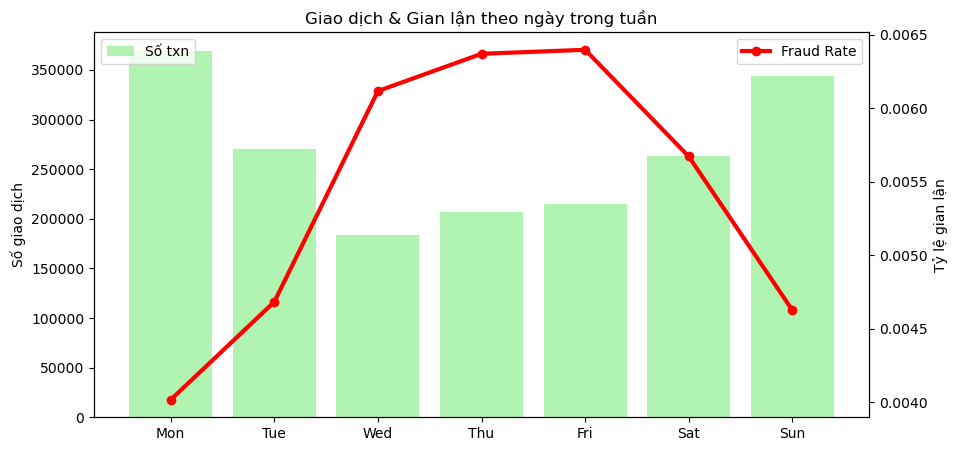

In [39]:
dow_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
dow_count = df.groupby('day_of_week').size()
dow_fraud = df.groupby('day_of_week')['is_fraud'].mean()

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(dow_count.index.map(dow_map), dow_count.values, color='lightgreen', alpha=0.7, label='Số txn')
ax1.set_ylabel('Số giao dịch')

ax2 = ax1.twinx()
ax2.plot(dow_fraud.index.map(dow_map), dow_fraud.values, color='red', marker='o', linewidth=3, label='Fraud Rate')
ax2.set_ylabel('Tỷ lệ gian lận')

ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.title('Giao dịch & Gian lận theo ngày trong tuần')
plt.show()

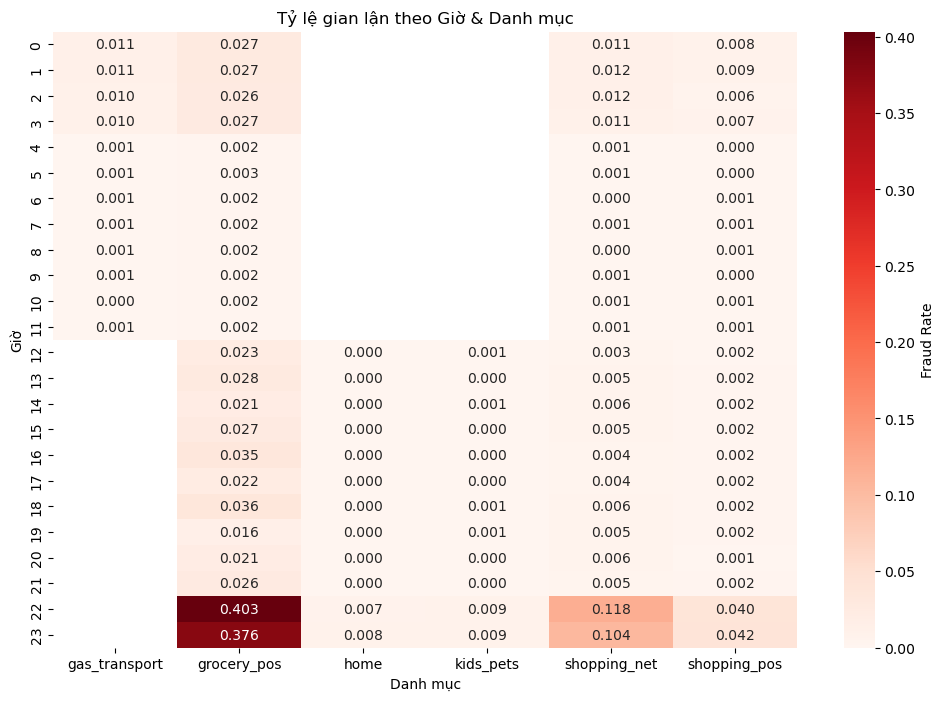

In [40]:
top_cats = df['category'].value_counts().head(6).index
pivot = df[df['category'].isin(top_cats)].pivot_table(
    values='is_fraud', index='hour', columns='category', aggfunc='mean'
)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, cmap='Reds', fmt='.3f', cbar_kws={'label': 'Fraud Rate'})
plt.title('Tỷ lệ gian lận theo Giờ & Danh mục')
plt.ylabel('Giờ'); plt.xlabel('Danh mục')
plt.show()

In [41]:
# KRI : Giao dịch xa + nhanh
df['high_risk_geo'] = ((df['distance_km'] > 800) & (df['speed_kmh'] > 500)).astype(int)

# KRI : Quốc tế + đêm khuya
df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['international_night'] = (df['is_international'] & df['hour'].between(0,5)).astype(int)

# Fraud rate
print("High risk geo fraud rate:", df['high_risk_geo'].mean())
print("International night fraud rate:", df[df['international_night']==1]['is_fraud'].mean())

High risk geo fraud rate: 0.0
International night fraud rate: 0.014009661835748793


In [42]:
# KRI: Night + High velocity
df['night_high_vel'] = (df['is_late_night'] & (df['txn_count_1h'] > 5)).astype(int)

# KRI: Weekend + Large amount
df['weekend_large_amt'] = (df['is_weekend'] & (df['amt'] > 500)).astype(int)

# KRI: Burst (3+ txn trong 10 phút)
df['time_since_last_min'] = df['time_since_last_sec'] / 60
df['burst_10min'] = (df['txn_streak'] >= 3) & (df['time_since_last_min'] < 10)

print("Night high velocity fraud rate:", df[df['night_high_vel']==1]['is_fraud'].mean())
print("Weekend large amt fraud rate:", df[df['weekend_large_amt']==1]['is_fraud'].mean())
print("Burst 10min fraud rate:", df[df['burst_10min']]['is_fraud'].mean())

Night high velocity fraud rate: nan
Weekend large amt fraud rate: 0.21634062140391255
Burst 10min fraud rate: 0.04159848961611076


Top features tương quan với is_fraud:
amt                    0.209308
txn_count_1h           0.103262
txn_streak             0.071446
is_night               0.028158
time_since_last_sec    0.015947
hour                   0.013196
speed_kmh              0.011887
age                    0.011062
is_international       0.003171
txn_count_24h          0.000568
Name: is_fraud, dtype: float64


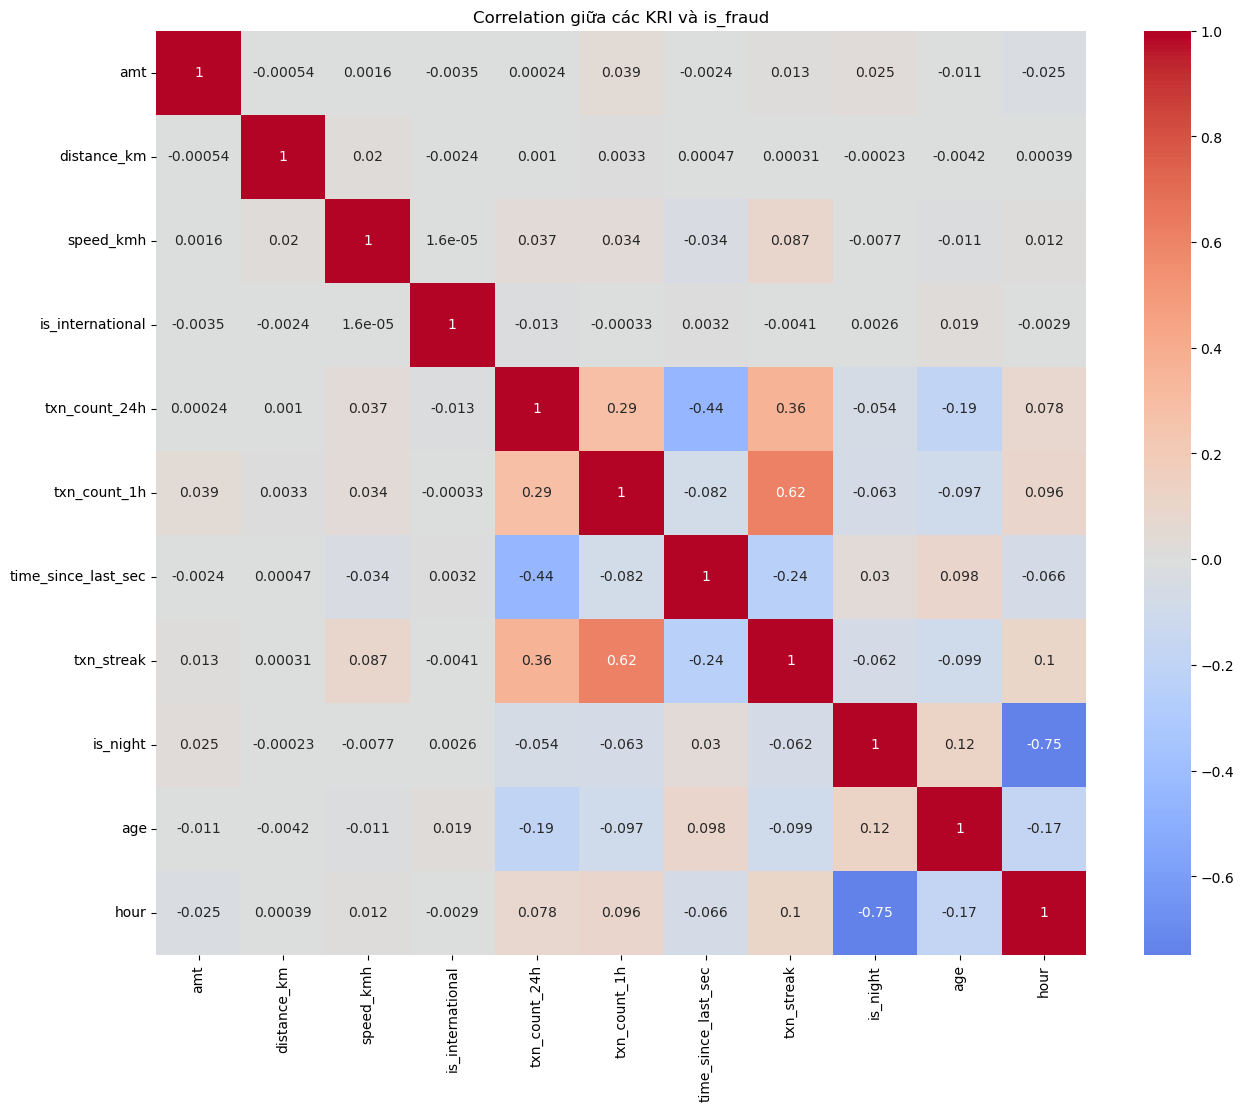

In [43]:
feature_cols = ['amt', 'distance_km', 'speed_kmh', 'is_international',
                'txn_count_24h', 'txn_count_1h', 'time_since_last_sec', 'txn_streak', 'is_night',
                'age', 'hour']

# Tính correlation với is_fraud
corr_with_fraud = df[feature_cols + ['is_fraud']].corr()['is_fraud'].drop('is_fraud')
corr_with_fraud = corr_with_fraud.abs().sort_values(ascending=False)

print("Top features tương quan với is_fraud:")
print(corr_with_fraud.head(10))

corr_matrix = df[feature_cols].corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation giữa các KRI và is_fraud')
plt.show()

## Feature Engineering

In [44]:
def feature_engineering(df):
    df = df.copy()
    # Tương tác giữa số tiền và tần suất giao dịch
    df['amt_txn1h_interaction'] = df['amt'] * (df['txn_count_1h'] + 1)
    df['amt_txn24h_interaction'] = df['amt'] * (df['txn_count_24h'] + 1)

    # Giao dịch lớn với tần suất thấp
    df['large_amt_low_freq_1h'] = ((df['amt'] > 500) & (df['txn_count_1h'] < 3)).astype(int)

    # Tốc dộ di chuyển bất thường
    df['time_since_last_hour'] = df['time_since_last_sec'] / 3600
    df['effective_speed_kmh'] = df['distance_km'] / (df['time_since_last_hour'] + 1e-6)
    df['unusual_speed'] = (df['effective_speed_kmh'] > 500).astype(int)

    # Giao dịch quá nhanh liên tiếp
    df['fast_txn_streak'] = ((df['time_since_last_sec'] < 60).astype(int)).groupby((df['time_since_last_sec'] >= 60).cumsum()).cumcount() + 1
    df['fast_txn_streak_flag'] = (df['fast_txn_streak'] >= 5).astype(int)

    # Hành vi bất thường ban đêm
    df['night_risk'] = df['is_night'] * df['txn_streak']
    df['late_night_high_amt'] = (df['is_night'] & (df['hour'].isin([0,1,2,3,4])) & 
                                    (df['amt'] > df['amt'].quantile(0.9))).astype(int)
    # Tương tác số tiền và chuỗi giao dịch
    df['streak_amt_ratio'] = df['amt'] / (df['txn_streak'] + 1)
    df['long_streak'] = (df['txn_streak'] >= 5).astype(int)

    # Phát hiện outlier số tiền giao dịch
    df['amt_z'] = (df['amt'] - df['amt'].mean()) / df['amt'].std()
    df['amt_outlier'] = (df['amt_z'].abs() > 3).astype(int)
    df['freq_outlier_1h'] = (df['txn_count_1h'] > df['txn_count_1h'].quantile(0.99)).astype(int)

    # Tỷ lệ và biến đổi log số tiền giao dịch
    df['log_amt'] = np.log1p(df['amt'])
    df['log_distance'] = np.log1p(df['distance_km'])
    df['log_speed'] = np.log1p(df['speed_kmh'])

    # Giao dịch quốc tế với tần suất cao, số tiền lớn
    df['intl_high_freq'] = (df['is_international'] & (df['txn_count_1h'] > 5)).astype(int)
    df['intl_large_amt'] = (df['is_international'] & (df['amt'] > 500)).astype(int)
    return df
df = feature_engineering(df)

In [45]:
# Label encode categorical
cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [46]:
# Chọn features
feature_cols = ['amt', 'distance_km', 'speed_kmh', 'is_international',
                'txn_count_24h', 'txn_count_1h', 'time_since_last_sec', 'txn_streak', 'is_night',
                'age', 'hour',
                'merchant', 'category','gender','city','state','job'
                ]

In [47]:
selected_features = feature_cols + [
    'amt_txn1h_interaction', 'amt_txn24h_interaction',
    'large_amt_low_freq_1h', 'unusual_speed', 'fast_txn_streak_flag',
    'night_risk', 'late_night_high_amt', 'streak_amt_ratio', 'long_streak',
    'amt_outlier', 'freq_outlier_1h',
    'log_amt', 'log_distance', 'log_speed',
    'intl_high_freq', 'intl_large_amt'
]

X = df[selected_features]
y = df['is_fraud']

## Imbalanced

In [48]:
# Scale amt, thời gian và khoảng cách
scaler = StandardScaler()
X['amt'] = scaler.fit_transform(X[['amt']])
X['hour'] = scaler.fit_transform(X[['hour']])
X['distance_km'] = scaler.fit_transform(X[['distance_km']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\4089423553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['amt'] = scaler.fit_transform(X[['amt']])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\4089423553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hour'] = scaler.fit_transform(X[['hour']])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\4089423553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

Train fraud rate: 0.005210150379745127
Test fraud rate: 0.005209472061844261


In [49]:
# Đánh giá mô hình
results = []
def evaluate_model(model, X_val, y_val, method_name):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    auc = accuracy_score(y_val, y_pred)
    auc_pr = average_precision_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    results.append({
        'Method': method_name,
        'AUC': round(auc, 4),
        'AUC_PR': round(auc_pr, 4),
        'F1-Fraud': round(f1, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4)
    })
    print(f"\n=== {method_name} ===")
    print(f"AUC: {auc:.4f} |AUC_PR : {auc_pr:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

In [50]:
# Sử dụng class weight để xử lý imbalanced
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

model_cw = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # hoặc {0:1, 1:scale_pos_weight}
    random_state=42,
    n_jobs=-1
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

model_cw.fit(X_train, y_train)
y_pred = model_cw.predict(X_val)
evaluate_model(model_cw, X_val, y_val, "RF + Class Weight")

scale_pos_weight: 190.93

=== RF + Class Weight ===
AUC: 0.9982 |AUC_PR : 0.8908 | F1: 0.8052 | Precision: 0.9474 | Recall: 0.7001


In [51]:
# Fill missing values before SMOTE
# Create imputer for numerical columns
imputer = SimpleImputer(strategy='mean')
X_train_filled = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val_filled = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Apply SMOTE on the filled data
smote = SMOTE(random_state=42, sampling_strategy=0.1)  # 10% fraud
X_res, y_res = smote.fit_resample(X_train_filled, y_train)

print(f"Sau SMOTE: {y_res.value_counts()}")

# Train model with SMOTE-resampled data
model_smote = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_smote.fit(X_res, y_res)
evaluate_model(model_smote, X_val, y_val, "RF + SMOTE")

Sau SMOTE: is_fraud
0    1179355
1     117935
Name: count, dtype: int64

=== RF + SMOTE ===
AUC: 0.9984 |AUC_PR : 0.8772 | F1: 0.8338 | Precision: 0.9136 | Recall: 0.7668


In [52]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.1)
X_under, y_under = rus.fit_resample(X_train, y_train)

model_under = RandomForestClassifier(n_estimators=100, random_state=42)
model_under.fit(X_under, y_under)
evaluate_model(model_under, X_val, y_val, "RF + Undersampling")


=== RF + Undersampling ===
AUC: 0.9954 |AUC_PR : 0.8504 | F1: 0.6688 | Precision: 0.5386 | Recall: 0.8821


In [53]:
# XGBoost với scale_pos_weight
model_xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)
evaluate_model(model_xgb, X_val, y_val, "XGBoost + scale_pos_weight")

c:\Users\ADMIN\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:24:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost + scale_pos_weight ===
AUC: 0.9930 |AUC_PR : 0.9300 | F1: 0.5886 | Precision: 0.4238 | Recall: 0.9631


In [54]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='AUC', ascending=False).reset_index(drop=True)
results_df.index = results_df.index + 1

print("\n" + "="*70)
print("                BẢNG SO SÁNH 4 PHƯƠNG PHÁP XỬ LÝ IMBALANCED")
print("="*70)
print(results_df.to_string(index=True))
print("="*70)


                BẢNG SO SÁNH 4 PHƯƠNG PHÁP XỬ LÝ IMBALANCED
                       Method     AUC  AUC_PR  F1-Fraud  Precision  Recall
1                  RF + SMOTE  0.9984  0.8772    0.8338     0.9136  0.7668
2           RF + Class Weight  0.9982  0.8908    0.8052     0.9474  0.7001
3          RF + Undersampling  0.9954  0.8504    0.6688     0.5386  0.8821
4  XGBoost + scale_pos_weight  0.9930  0.9300    0.5886     0.4238  0.9631


## Model Selecting

In [55]:
# Fill missing values before training
imputer = SimpleImputer(strategy='mean')
X_train_filled = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_filled = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Logistic Regression baseline
model_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000, 
    random_state=42,
    n_jobs=-1
)
model_lr.fit(X_train_filled, y_train) 
y_test_pred = model_lr.predict(X_test_filled)
y_test_prob = model_lr.predict_proba(X_test_filled)[:, 1]

In [56]:
# Random Forest 
final_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

In [57]:
# XGBoost 
xgb_final = XGBClassifier(
    eval_metric='aucpr',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_final.fit(X_train, y_train)

c:\Users\ADMIN\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:31:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [58]:
# LGBM 
lgb_final = LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgb_final.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6177, number of negative: 1179355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 1185532, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251890
[LightGBM] [Info] Start training from score -5.251890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.8, max_depth=6, n_estimators=200, n_jobs=-1,
               random_state=42, subsample=0.8)

In [59]:
# Define list to store results
results_model = []

def evaluate_model(model, X_val, y_val, method_name):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    
    auc = accuracy_score(y_val, y_pred)
    auc_pr = average_precision_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)
    
    results_model.append({
        'Method': method_name,
        'AUC': round(auc, 4),
        'AUC_PR': round(auc_pr, 4),
        'F1-Fraud': round(f1, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'ROC-AUC': round(roc_auc, 4)
    })
    print(f"\n=== {method_name} ===")
    print(f"AUC: {auc:.4f} | AUC-PR: {auc_pr:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | ROC-AUC: {roc_auc:.4f}")

for model, X_data, y_data, name in [
    (model_lr, X_test_filled, y_test, "Logistic Regression"),
    (final_model, X_test, y_test, "RF"),
    (xgb_final, X_test, y_test, "XGBoost"),
    (lgb_final, X_test, y_test, "LGBM")
]:
    evaluate_model(model, X_data, y_data, name)


=== Logistic Regression ===
AUC: 0.9417 | AUC-PR: 0.1969 | F1: 0.1195 | Precision: 0.0649 | Recall: 0.7596 | ROC-AUC: 0.8609

=== RF ===
AUC: 0.9983 | AUC-PR: 0.8879 | F1: 0.8099 | Precision: 0.9530 | Recall: 0.7041 | ROC-AUC: 0.9870

=== XGBoost ===
AUC: 0.9987 | AUC-PR: 0.9279 | F1: 0.8649 | Precision: 0.9377 | Recall: 0.8026 | ROC-AUC: 0.9961

=== LGBM ===
AUC: 0.9980 | AUC-PR: 0.7952 | F1: 0.8003 | Precision: 0.8208 | Recall: 0.7808 | ROC-AUC: 0.9700


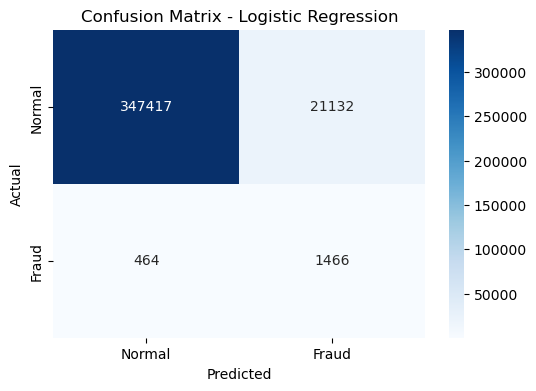

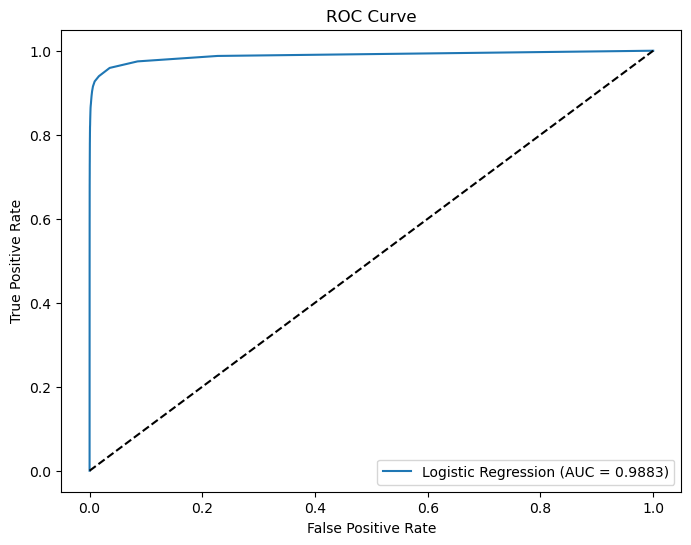

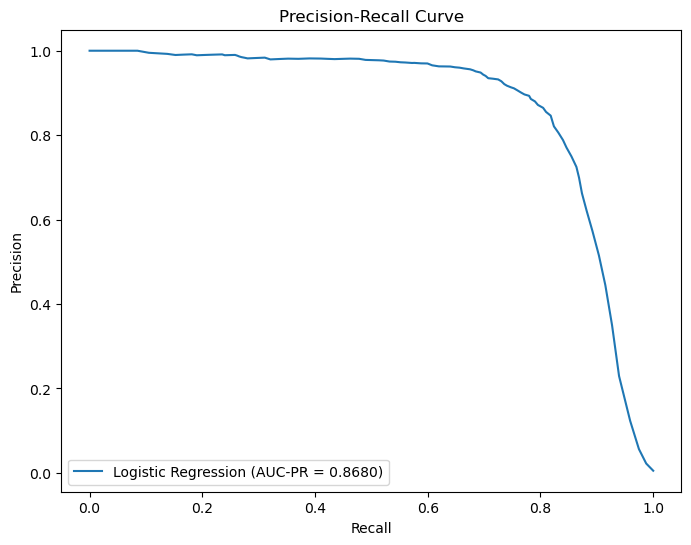

In [60]:
# Confusion Matrix for the best model
conf_matrix = cm(y_test, model_lr.predict(X_test_filled))
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# roc curve
from sklearn.metrics import roc_curve
y_test_prob = final_model.predict_proba(X_test_filled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Logistic Regression (AUC-PR = {:.4f})'.format(average_precision_score(y_test, y_test_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

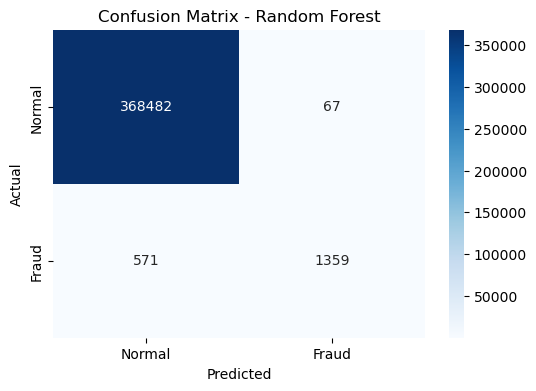

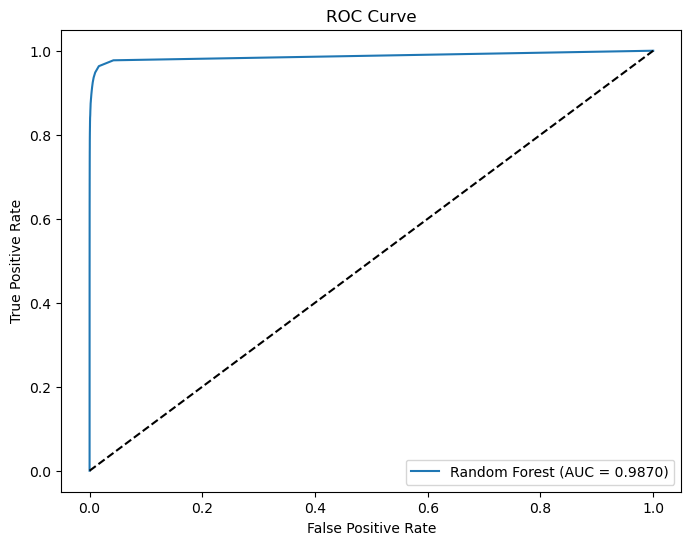

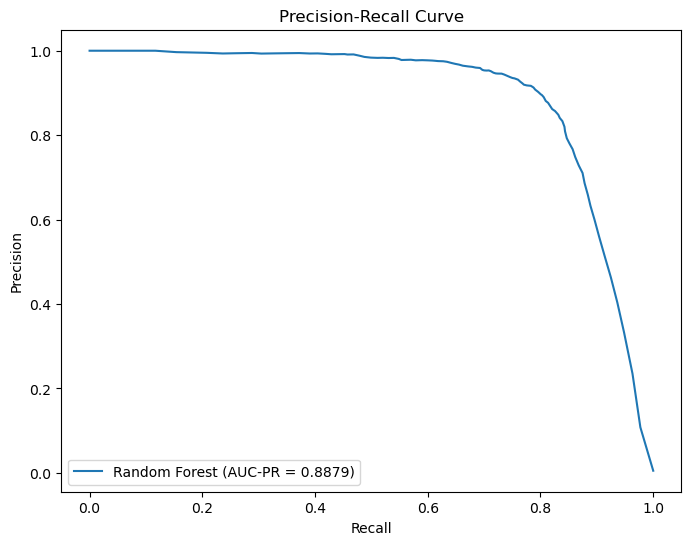

In [61]:
# Confusion Matrix for the best model
conf_matrix = cm(y_test, final_model.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# roc curve
from sklearn.metrics import roc_curve
y_test_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Random Forest (AUC-PR = {:.4f})'.format(average_precision_score(y_test, y_test_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

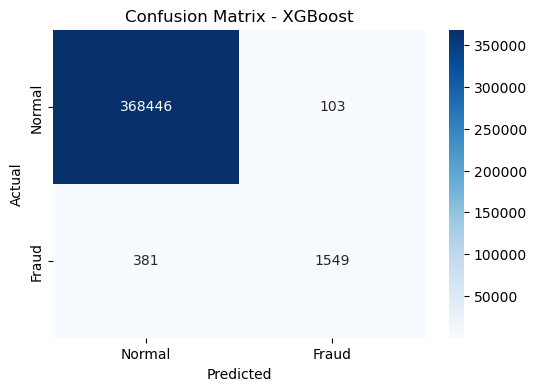

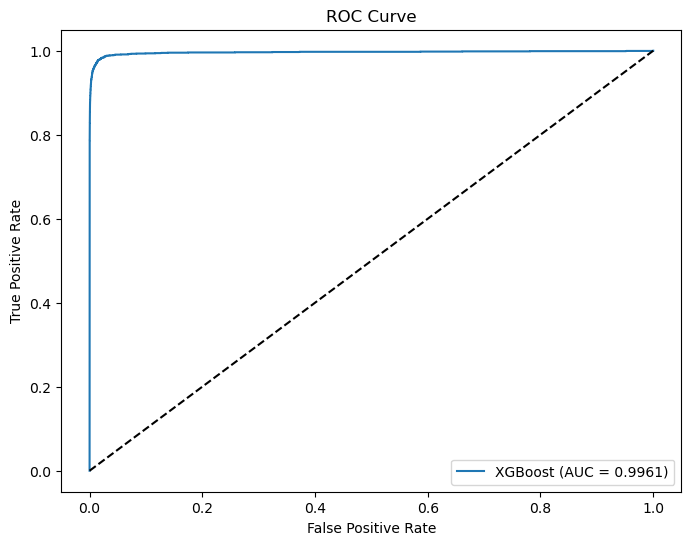

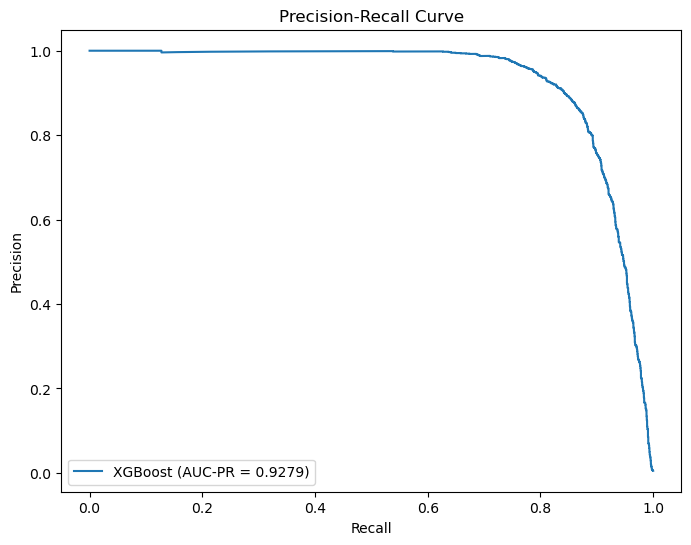

In [62]:
# Confusion Matrix for the best model
conf_matrix = cm(y_test, xgb_final.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# roc curve
from sklearn.metrics import roc_curve
y_test_prob = xgb_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='XGBoost (AUC-PR = {:.4f})'.format(average_precision_score(y_test, y_test_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

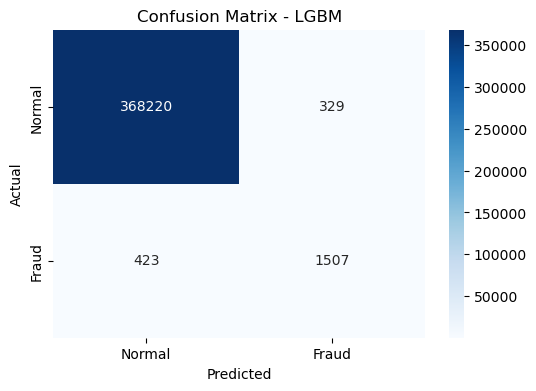

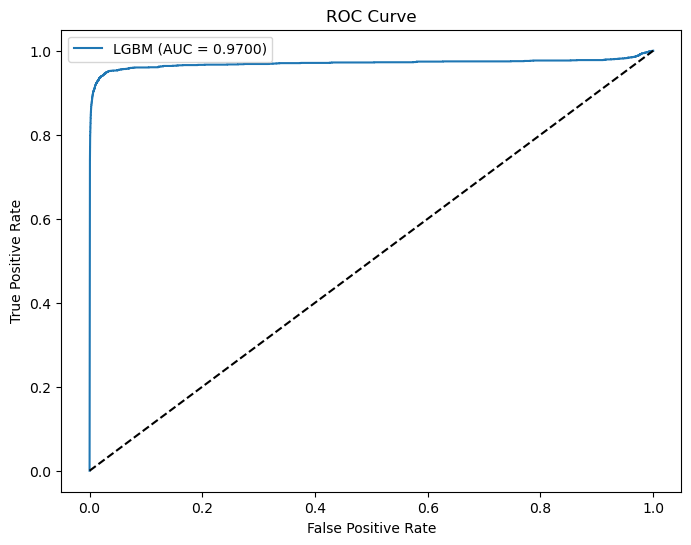

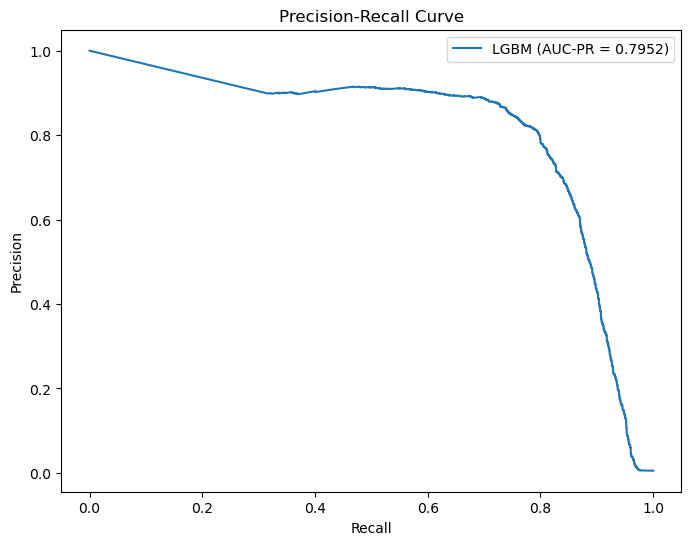

In [63]:
# Confusion Matrix for the best model
conf_matrix = cm(y_test, lgb_final.predict(X_test))
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LGBM')
plt.show()

# roc curve
from sklearn.metrics import roc_curve
y_test_prob = lgb_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='LGBM (AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_prob)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='LGBM (AUC-PR = {:.4f})'.format(average_precision_score(y_test, y_test_prob)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [64]:
result_model_df = pd.DataFrame(results_model)
result_model_df = result_model_df.sort_values(by='F1-Fraud', ascending=False).reset_index(drop=True)
result_model_df.index = result_model_df.index + 1

print("\n" + "="*70)
print("                BẢNG SO SÁNH 4 MÔ HÌNH CUỐI CÙNG")
print("="*70)
print(result_model_df.to_string(index=True))
print("="*70)


                BẢNG SO SÁNH 4 MÔ HÌNH CUỐI CÙNG
                Method     AUC  AUC_PR  F1-Fraud  Precision  Recall  ROC-AUC
1              XGBoost  0.9987  0.9279    0.8649     0.9377  0.8026   0.9961
2                   RF  0.9983  0.8879    0.8099     0.9530  0.7041   0.9870
3                 LGBM  0.9980  0.7952    0.8003     0.8208  0.7808   0.9700
4  Logistic Regression  0.9417  0.1969    0.1195     0.0649  0.7596   0.8609


In [65]:
import joblib

def save_model(model, model_name):
    joblib.dump(model, f'{model_name}.joblib')
    print(f'Model saved as {model_name}.joblib')

def save_best_model(model, model_name):
    results_model_df = pd.DataFrame(results_model)
    best_idx = results_model_df['F1-Fraud'].idxmax()
    best_model_name = results_model_df.loc[best_idx, 'Method']
    best_model = models[best_model_name]  # Get the model from models dictionary
    best_f1 = results_model_df.loc[best_idx, 'F1-Fraud']

    best_path = f'best_model_{best_model_name}_F1_Fraud_{best_f1:.4f}.joblib'
    joblib.dump(best_model, best_path)
    print(f'Best model saved as {best_path}')

    print(f"\n🔥 Best model by F1-score: {best_model_name}")
    print(f"F1-score = {best_f1:.4f}")
    print(f"✅ Saved best model to: {best_path}")

    return best_model, best_model_name, best_f1

In [66]:
models = {
    'LogisticRegression': model_lr,
    'RandomForest': final_model,
    'XGBoost': xgb_final,
    'LGBM': lgb_final
}

In [67]:
# Fill missing values before model training
imputer = SimpleImputer(strategy='mean')
X_train_filled = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_filled = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns) 
X_val_filled = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Dictionary to track evaluation results
evaluation_results = []

# Train and evaluate each model
for name, model in models.items():
    if name == 'LogisticRegression':
        # Use imputed data for LogisticRegression
        model.fit(X_train_filled, y_train)
        evaluate_model(model, X_val_filled, y_val, name)
    else:
        # Other models can handle NaN
        model.fit(X_train, y_train)
        evaluate_model(model, X_val, y_val, name)

# Get the best model based on F1 score
results_df = pd.DataFrame(results_model)
if not results_df.empty:
    best_idx = results_df['F1-Fraud'].idxmax()
    best_name = results_df.loc[best_idx, 'Method']
    best_model = models[best_name]
    
    # Save the best model
    best_model, best_name, best_f1 = save_best_model(best_model, best_name)


=== LogisticRegression ===
AUC: 0.9414 | AUC-PR: 0.1967 | F1: 0.1186 | Precision: 0.0644 | Recall: 0.7571 | ROC-AUC: 0.8688

=== RandomForest ===
AUC: 0.9982 | AUC-PR: 0.8908 | F1: 0.8052 | Precision: 0.9474 | Recall: 0.7001 | ROC-AUC: 0.9836


c:\Users\ADMIN\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:38:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
AUC: 0.9987 | AUC-PR: 0.9243 | F1: 0.8633 | Precision: 0.9297 | Recall: 0.8057 | ROC-AUC: 0.9966
[LightGBM] [Info] Number of positive: 6177, number of negative: 1179355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 1185532, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251890
[LightGBM] [Info] Start training from score -5.251890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

=== LGBM ===
AUC: 0.9979 | AUC-PR: 0.7847 | F1: 0.7911 | Precision: 0.8161 | Recall: 0.7675 | ROC-AUC: 0.9630
Best model saved as best_model_XGBoost_F1_Fraud_0.8649.joblib

🔥 Best model by F1-score: XGBoost
F1-score = 0.8649
✅ Saved best model to: b

## Feature Importance

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22920\1347280797.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')


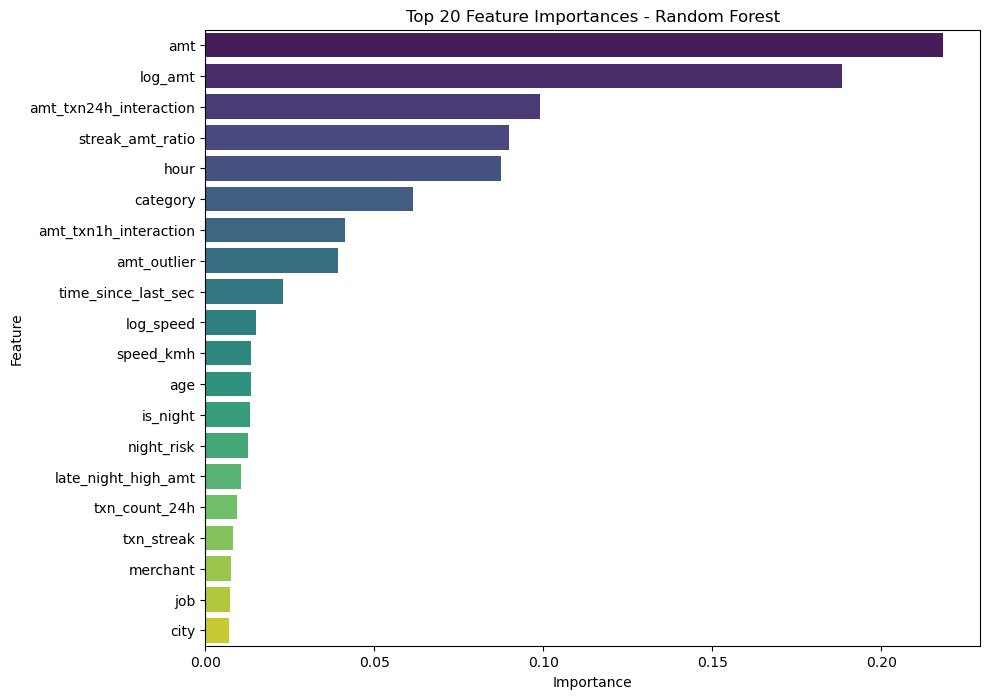

In [68]:
# Best model feature importance
importances = final_model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.show()

## HyperParameter (Optuna)

In [69]:
import optuna

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # nông → nhanh
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }
    
    model = XGBClassifier(**params, random_state=42, eval_metric='auc')
    model.fit(X_res, y_res)
    prob = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, prob)

In [70]:
# Tạo study
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20),
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Chạy 50 trials (có thể tăng lên 100)
study.optimize(objective, n_trials=50, timeout=3600) 

print("Best AUC-PR:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-11-01 17:39:39,878] A new study created in memory with name: no-name-aa874596-8d4a-48d7-9278-4af799b80d7e
[I 2025-11-01 17:40:01,435] Trial 0 finished with value: 0.9962882010458688 and parameters: {'learning_rate': 0.11861663446573512, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.9962882010458688.
[I 2025-11-01 17:40:22,494] Trial 1 finished with value: 0.9910384713152576 and parameters: {'learning_rate': 0.026844247528777843, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 4.8495492608099715}. Best is trial 0 with value: 0.9962882010458688.
[I 2025-11-01 17:40:36,930] Trial 2 finished with value: 0.9949772632366415 and parameters: {'learning_rate': 0.2514083658321223, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'g

Best AUC-PR: 0.9976664079805363
Best params:
  learning_rate: 0.2551175356282457
  max_depth: 7
  min_child_weight: 9
  subsample: 0.7139868677890794
  colsample_bytree: 0.7626353078936776
  gamma: 2.0680398848282353


In [72]:
joblib.dump(model, 'fraud_detection_model.pkl')
joblib.dump(selected_features, 'feature_columns.pkl')

['feature_columns.pkl']